In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
import sys
assert 'zipfile' in sys.modules
import math
import seaborn as sns
import matplotlib.pyplot as plt

# import the widgets module
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import scipy.stats as ss
from collections import Counter
import warnings
from sklearn.preprocessing import OneHotEncoder
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1xoZGzL7mbE4AgqoXCECgNqEXeYS8ZJ5P/view?usp=sharing'
#fluff, id = link.split('=')
id = '1xoZGzL7mbE4AgqoXCECgNqEXeYS8ZJ5P'
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Audience_LA_DMA.csv')  



1xoZGzL7mbE4AgqoXCECgNqEXeYS8ZJ5P


# MODEL PROTOTYPE V.1:


## The Narrative: 
Our product is a solution to an industry-wide dilemma of how to keep data unbiased once put through a workflow. We want to ensure that the data accurately represents the population of the datafied world. Our goal is to ultimately make a tool useful to Kinesso, and in general advertisement firms and their clients, who would want their actual audience pool to be wider and more representative of the intended audience.



## The Solution: 

A common fix to unbiasing the data is to keep on introducing new clean data. However, the data inevitably is sullied. Our solution tackles bias during the early stages of workflow, specifically during audience assembly. The product will accompany the SQL like workflow of Kinesso in building their audiences for campaigns, and alarm the user when there is potential bias in their audience selection.


EXAMPLE OF WORKFLOW WITH SOME EDA: 

**disclaimer: the following scenario is a very simplified version of what actually happens in the real world** 

Our client Toyota asks us to help them run a campaign in LA. We go to our vast database and start building an audience. We start with a vast dataset of past log events with geographical information. 
 


In [ ]:
df = pd.read_csv('Audience_LA_DMA.csv')
df.head(10)

,Unnamed: 0,ZIP,GENDER,AGE,DEMO_HH_INCOME,ETHNICITY,HOMEOWNERSHIP_STATUS
0,0,90290,F,35.0,"$75,000 to $99,999",White,Homeowner
1,1,90036,F,37.0,"$100,000 to $149,999",White,Homeowner
2,2,92376,M,51.0,"$30,000 to $49,999",White,Homeowner
3,3,91767,F,81.0,"Less than $30,000",Asian,Homeowner
4,4,92345,F,29.0,"$30,000 to $49,999",White,Renter
5,5,92225,M,63.0,"$50,000 to $74,999",Hispanic,Homeowner
6,6,90032,F,69.0,"$75,000 to $99,999",Hispanic,Renter
7,7,90301,M,69.0,"Less than $30,000",White,Renter
8,8,90814,M,57.0,"$50,000 to $74,999",White,Homeowner
9,9,90810,F,99.0,"$30,000 to $49,999",Hispanic,Homeowner


In [ ]:
df = df.replace('NaN',0)


Toyota asked us to find clients that would be interested in buying their Toyota Siennas! We start by looking for households that own homes, and that approximatley earn on average,[ a yearly household income of $111,500](https://motorandwheels.com/11-toyota-sienna-statistics-facts/#:~:text=Sienna%20buyers%20are%20younger%20than,yearly%20household%20income%20of%20%24111%2C500).

In [ ]:
sienna= df[df['HOMEOWNERSHIP_STATUS'] == 'Homeowner']

In [ ]:
len(df.index) - len(sienna.index) 

3033882

(<seaborn.axisgrid.FacetGrid at 0x7f11f598fe90>,
 <seaborn.axisgrid.FacetGrid at 0x7f11f2af0e90>)

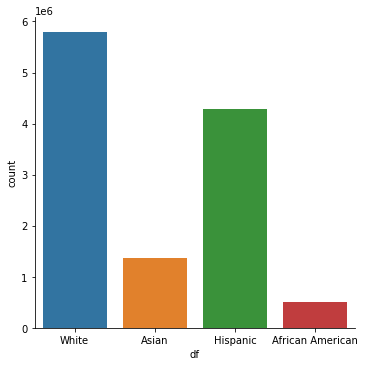

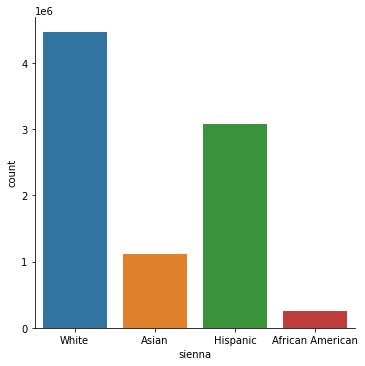

In [ ]:
compare = pd.DataFrame({
    'df':df.ETHNICITY,
    'sienna': sienna.ETHNICITY
})

sns.catplot(x="df", kind="count", data=compare), sns.catplot(x="sienna", kind="count", data=compare)
 

In [ ]:
df.DEMO_HH_INCOME.unique()

array(['$75,000 to $99,999', '$100,000 to $149,999', '$30,000 to $49,999',
       'Less than $30,000', '$50,000 to $74,999', '$250,000 +',
       '$200,000 to $249,999', '$150,000 to $199,999'], dtype=object)

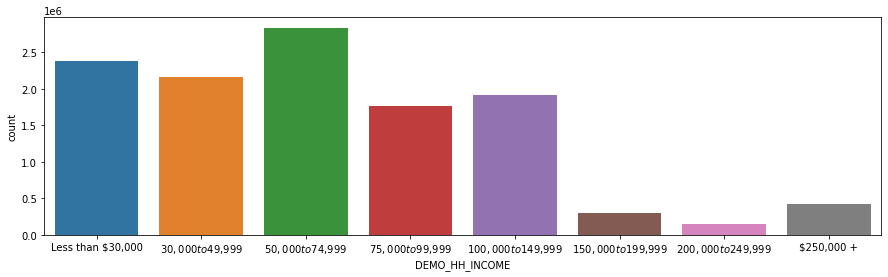

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.countplot(x="DEMO_HH_INCOME", order = ['Less than $30,000', '$30,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '$250,000 +'], ax = ax, data=df)

Simple count of how many people of each race are in each income bracket. All bars in each group should add to 100%

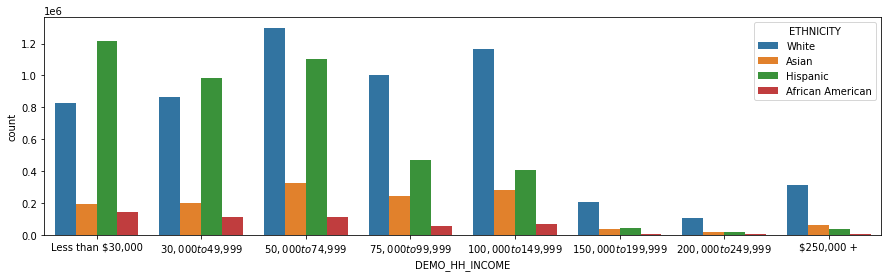

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x="DEMO_HH_INCOME", order = ['Less than $30,000', '$30,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999', 
                                           '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', 
                                           '$250,000 +'], hue = 'ETHNICITY',hue_order = ['White', 'Asian', 'Hispanic', 'African American'],  ax = ax, data=df)

Normailzed count of how many people of each race are in each income bracket. All bars in each group should add to 100%. Sanity check - it should look very similar to the above graph.

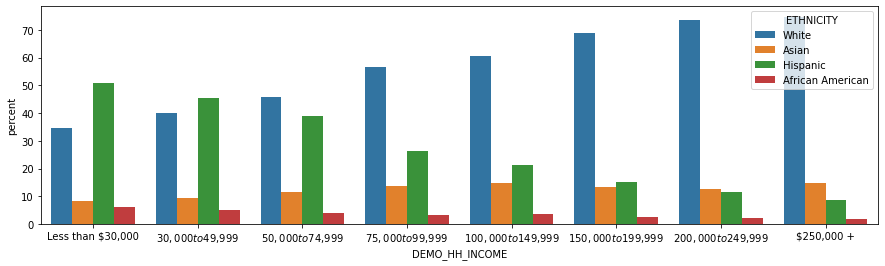

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)

#sns.set(color_codes=True)

df_plot = df

x,y = 'DEMO_HH_INCOME', 'ETHNICITY'

df_plot = df_plot.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

sns.barplot(x=x, y='percent', hue=y, order = ['Less than $30,000', '$30,000 to $49,999',
                                              '$50,000 to $74,999', '$75,000 to $99,999', '$100,000 to $149,999', 
                                              '$150,000 to $199,999', '$200,000 to $249,999', 
                                              '$250,000 +'], hue_order = ['White', 'Asian', 'Hispanic', 'African American'], ax=ax, data = df_plot)

Race by income - shows the percentage of people of a certain race who are in a certain bracket. All the bars for one race add to 100%

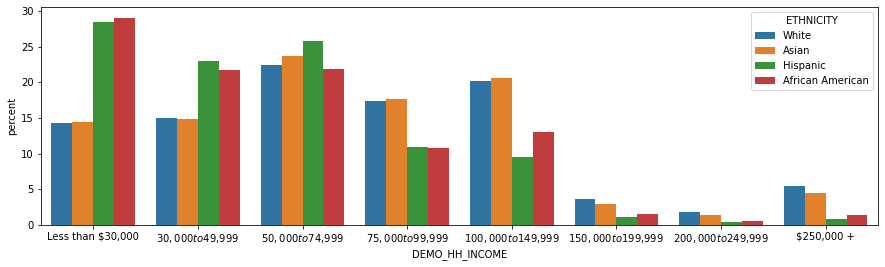

In [ ]:
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)

df_plot = df

x,y = 'ETHNICITY', 'DEMO_HH_INCOME'


df_plot = df_plot.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

sns.barplot(x=y, y='percent', hue=x, order = ['Less than $30,000', '$30,000 to $49,999', 
                                              '$50,000 to $74,999', '$75,000 to $99,999', '$100,000 to $149,999', 
                                              '$150,000 to $199,999', '$200,000 to $249,999', 
                                              '$250,000 +'], hue_order = ['White', 'Asian', 'Hispanic', 'African American'],  ax=ax, data = df_plot)

In [ ]:
sienna= df[df['HOMEOWNERSHIP_STATUS'] == 'Homeowner']

In [ ]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

**POTENTIALLY ADD EDA HERE**

### DEMO of prototype V1: 

# Conditional Entropy and Correlational Heatmaps 


Here we take a deeper dive into the relationships between the various features in our data. To do so, we use the entropy between the variables to innvestigate a few statistics that are similar to correlation coefficients, but are adjusted for categorical data. 

credits to Shaked Zychlinski for providing us with preliminary code to explore these relationships.



In [ ]:
df2 = df
df2 = df2.rename(columns = {'ETHNICITY': 'RACE', 'Unnamed: 0':'ID'})
df2['ZIP'] = df2['ZIP'].astype(str)

In [ ]:
_REPLACE = 'replace'
_DEFAULT_REPLACE_VALUE = 0.0

In [ ]:
def replace_nan_with_value(x, y, value):
    x = np.array([v if v == v and v is not None else value for v in x])  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

In [ ]:
def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]

In [ ]:
def conditional_entropy(x,y,
                        nan_strategy=_REPLACE,
                        nan_replace_value=_DEFAULT_REPLACE_VALUE,
                        log_base: float = math.e):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.
    Returns:
    --------
    float
    """
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

In [ ]:
def theils_u(x,
             y,
             nan_strategy=_REPLACE,
             nan_replace_value=_DEFAULT_REPLACE_VALUE):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-
    categorical association. This is the uncertainty of x given y: value is
    on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    Returns:
    --------
    float in the range of [0,1]
    """
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

Conditional Entropy between 2 features:

In [ ]:
conditional_entropy(df2['RACE'],df2['HOMEOWNERSHIP_STATUS'])

1.0907465522677662

In [ ]:
df3 = 


SyntaxError: ignored

Below is some pseudo-code intended to traverse through all features within the data in order to generate conditional entropy values with other features in the dataset. 

In [ ]:
dictionary = dict()
for x in df2.columns:
    for y in df2.columns:
        dictionary[x + '_' + y] = conditional_entropy(df2[x],df2[y])
        print(dictionary[x + '_' + y])

we now know that the categorical data types we have are fit for generating the various metrics, now we put those metrics into a heatmap


In [ ]:
# creating a blank correlation matrix of dimension (num_features x num_feautres)
rows, cols = (len(df2.columns), len(df2.columns))
corra_matrix = [[0]*cols]*rows

In [ ]:
#populating the correlation matrix with our correlation metric of choice, in this case, conditional entropy
i = 0
for x in df2.columns:
    j = 0
    for y in df2.columns:
        
        corra_matrix [i][j]= conditional_entropy(df2[x],df2[y])
        j+=1
    i+=1

Resources: 



1.   https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

2.   https://github.com/shakedzy/dython/blob/master/dython/nominal.py








Author(s): Wei Dai, Sam Stilson, Michelle Gu, Lubah Nelson, Noor-Ul-Ain Ali

In [ ]:
widgets.IntSlider()